In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Lab 1

In [2]:
dataset_file = '../datasets/Hitters.csv'
data = pd.read_csv(dataset_file, index_col=0)
data = data.dropna()
data.League = data.League.apply(lambda v: 1 if v == 'N' else 0)
data.NewLeague = data.NewLeague.apply(lambda v: 1 if v == 'N' else 0)
data.Division = data.Division.apply(lambda v: 1 if v == 'W' else 0)
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,750.0,0


In [3]:
import statsmodels.api as sm
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor, as_completed

### No parallelizing

In [4]:
def best_subset_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    
    for k in range(1, p + 1):
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(X.columns, k)]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

### Parallelizing at level of single model

In [5]:
def test_model(X, y): 
    return X.columns.tolist(), sm.OLS(y, sm.add_constant(X)).fit().rsquared

def best_subset_selection2(X, y, max_jobs=None, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []

    with ProcessPoolExecutor(max_workers=max_jobs) as executor:
        for k in range(1, p + 1):
            futures = [executor.submit(test_model, X[list(names)], y) for names in combinations(X.columns, k)]
            results = [future.result() for future in as_completed(futures)]
            best_of_k[k] = max(results, key=lambda v: v[1])[0]
            if verbose:
                print(k, best_of_k[k])


    return best_of_k

### Parallelizing at level of k

In [6]:
def test_k(X, y, k):
    models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(X.columns, k)]
    return k, max(models, key=lambda model: model[1])[0]

def best_subset_selection3(X, y, max_jobs=None, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    
    with ProcessPoolExecutor(max_workers=max_jobs) as executor:
        
        futures = [executor.submit(test_k, X, y, k) for k in range(1, p + 1)]
        for future in as_completed(futures):
            best_of_k[future.result()[0]] = future.result()[1]
            if verbose:
                print(future.result()[0], future.result()[1])
        
    return best_of_k

In [7]:
%%time
p = 6
best_models = best_subset_selection(data.iloc[:, :p], data.Salary, verbose=False)

CPU times: user 293 ms, sys: 3.29 ms, total: 296 ms
Wall time: 529 ms


In [8]:
%%time
best_models = best_subset_selection2(data.iloc[:, :p], data.Salary, verbose=False)

CPU times: user 131 ms, sys: 36.4 ms, total: 167 ms
Wall time: 322 ms


In [9]:
%%time
best_models = best_subset_selection3(data.iloc[:, :p], data.Salary, verbose=False)

CPU times: user 11.4 ms, sys: 28.2 ms, total: 39.5 ms
Wall time: 221 ms


In [10]:
%%time
best_models = best_subset_selection3(data.iloc[:, :p], data.Salary, verbose=True)

1 ('RBI',)
5 ('AtBat', 'Hits', 'Runs', 'RBI', 'Walks')
6 ('AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks')
2 ('RBI', 'Walks')
4 ('AtBat', 'Hits', 'RBI', 'Walks')
3 ('AtBat', 'Hits', 'Walks')
CPU times: user 32.1 ms, sys: 13.1 ms, total: 45.3 ms
Wall time: 179 ms


In [11]:
def evaluate(best_of_k, data):
    metrics = pd.DataFrame(columns=['RSS', 'R_squared_adj', 'AIC', 'BIC'])

    for k, names in best_of_k.items():
        if k == 0:
            model = sm.OLS(data.Salary, np.ones(data.Salary.shape)).fit()
        else:
            model = sm.OLS(data.Salary, sm.add_constant(data[list(names)])).fit()
        metrics.loc[k] = [model.ssr, model.rsquared_adj, model.aic, model.bic]
    metrics.sort_index(inplace=True)

    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, col in enumerate(metrics.columns):
        sns.pointplot(metrics.index, metrics[col], marker='o', ax=axes[i%2, i//2], label=col,)
        best = metrics[col].argmax() if col == 'R_squared_adj' else metrics[col].argmin()
        axes[i%2, i//2].set_title(f'Best: {best}')
        sns.scatterplot([best], [metrics[col][best]], marker='o', s=200, color='m', ax=axes[i%2, i//2])

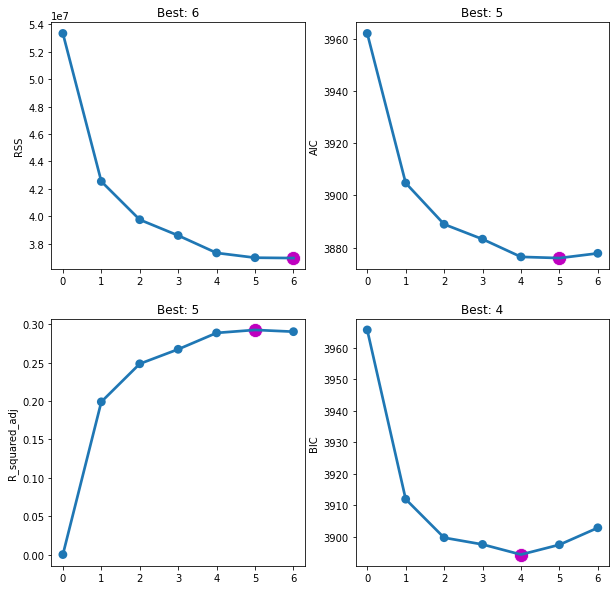

In [12]:
evaluate(best_models, data)

In [13]:
def forward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    for k in range(1, p + 1):
        names_candidates = [best_of_k[k - 1] + [name] for name in X.columns if name not in best_of_k[k - 1]]
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in names_candidates]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [14]:
%%time
best_models = forward_stepwise_selection(data.drop(['Salary'], axis=1), data.Salary, verbose=True)

1 ['CRBI']
2 ['CRBI', 'Hits']
3 ['CRBI', 'Hits', 'PutOuts']
4 ['CRBI', 'Hits', 'PutOuts', 'Division']
5 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat']
6 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks']
7 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks']
8 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns']
9 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
10 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
11 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League']
12 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs']
13 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs', 'Errors']
14 ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat',

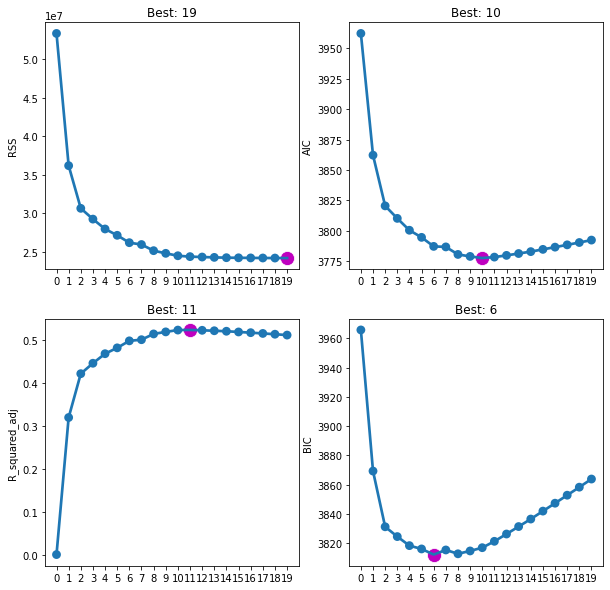

In [15]:
evaluate(best_models, data)

In [16]:
def backward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[p] = X.columns.tolist()
    best_of_k[0] = []

    for k in range(p - 1, 0, -1):
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(best_of_k[k+1], k)]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [17]:
%%time
best_models = backward_stepwise_selection(data.drop(['Salary'], axis=1), data.Salary, verbose=True)

18 ('AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague')
17 ('AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague')
16 ('AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors')
15 ('AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors')
14 ('AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors')
13 ('AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors')
12 ('AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'League', 'Div

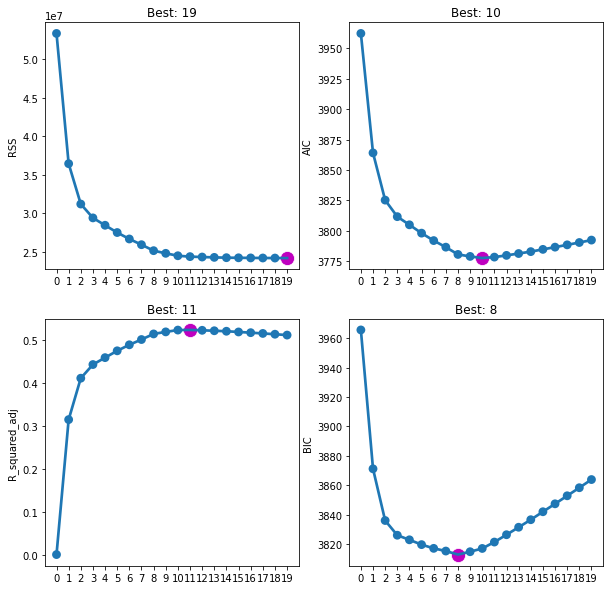

In [18]:
evaluate(best_models, data)

In [143]:
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error as mse

In [20]:
def evaluate(best_of_k, train, test):
    metrics = pd.DataFrame(columns=['MSE'])
    
    for k, names in best_of_k.items():
        if k == 0:
            model = sm.OLS(train.Salary, np.ones(train.Salary.shape)).fit()
        else:
            model = sm.OLS(train.Salary, sm.add_constant(train[names])).fit()
        metrics.loc[k] = [mse(test.Salary, model.predict(sm.add_constant(test[names])))]
    metrics.sort_index(inplace=True)
    
    sns.pointplot(metrics.index, metrics['MSE'], marker='o', label='MSE')
    best = metrics['MSE'].argmin()
    sns.scatterplot([best], [metrics['MSE'][best]], marker='o', s=200, color='m')
    return metrics

In [21]:
train, test = train_test_split(data, test_size=.25)

In [22]:
%%time
best_models = forward_stepwise_selection(train.drop(['Salary'], axis=1), train.Salary, verbose=False)

CPU times: user 727 ms, sys: 3.98 ms, total: 731 ms
Wall time: 730 ms


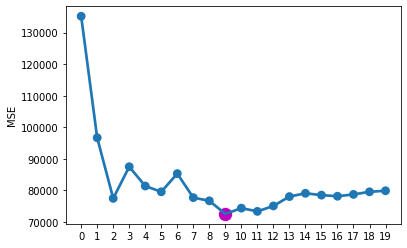

In [23]:
res = evaluate(best_models, train, test)

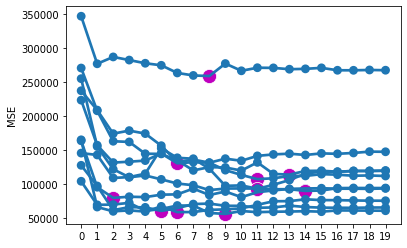

In [24]:
cv = KFold(n_splits=10, shuffle=True, random_state=22)
res = []
for train, test in cv.split(data):
    best_models = forward_stepwise_selection(data.iloc[train].drop(['Salary'], axis=1), data.iloc[train].Salary, verbose=False)
    res.append(evaluate(best_models, data.iloc[train], data.iloc[test]))
res = pd.concat(res, axis=1)
res['mean'] = res.mean(axis=1)
res.sort_index(inplace=True)

<AxesSubplot:ylabel='mean'>

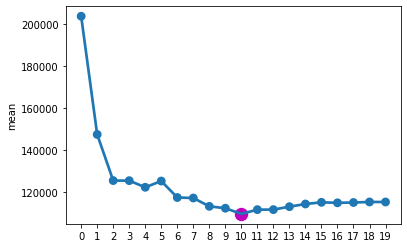

In [25]:
sns.pointplot(res.index, res['mean'], marker='o', label='MSE')
best = res['mean'].argmin()
sns.scatterplot([best], [res['mean'][best]], marker='o', s=200, color='m')

In [26]:
best_models = forward_stepwise_selection(data.drop(['Salary'], axis=1), data.Salary, verbose=False)
best_model = sm.OLS(data.Salary, sm.add_constant(data[best_models[best]])).fit()
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     29.64
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           2.80e-37
Time:                        20:42:03   Log-Likelihood:                -1877.8
No. Observations:                 263   AIC:                             3778.
Df Residuals:                     252   BIC:                             3817.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.5354     66.908      2.429      0.016      30.766     294.305
CRBI           0.7743      0.210      3.694      0.000       0.362       1.187
Hits           6.9180      1.647      4.201      0.000       3.675      10.161
PutOuts        0.2974      0.074      3.995      0.000       0.151       0.444
Division    -112.3801     39.214     -2.866      0.005    -189.610     -35.150
AtBat         -2.1687      0.536     -4.044      0.000      -3.225      -1.112
Walks          5.7732      1.585      3.643      0.000       2.652       8.894
CWalks        -0.8308      0.264     -3.152      0.002      -1.350      -0.312
CRuns          1.4082      0.390      3.607      0.000       0.639       2.177
CAtBat        -0.1301      0.055     -2.344      0.020      -0.239      -0.021
Assists        0.2832      0.158      1.796      0.074      -0.027       0.594
==============================================================================
Omnibus:                       91.407   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.766
Skew:                           1.288   Prob(JB):                    9.93e-108
Kurtosis:                       9.191   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lab 2

In [27]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

In [28]:
X = data.drop(['Salary'], axis=1)
std_X = X / X.std()
y = data.Salary

In [30]:
lambdas = np.logspace(-2, 10, 100)[::-1]
params = pd.DataFrame(columns=std_X.columns.insert(0, 'intercept'), index=lambdas)
for l in lambdas:
    model = Ridge(alpha=l, normalize=False).fit(std_X, y)
    params.loc[l] = [model.intercept_] + model.coef_.tolist()

In [31]:
index = 49
print(lambdas[index])
print(np.linalg.norm(params.iloc[index, 1:], 2))
params.loc[lambdas[index]]

11497.569953977356
15.487990935446117


intercept      453.685
AtBat           3.4898
Hits           3.94707
HmRun          2.98001
Runs           3.74941
RBI            3.97562
Walks          3.98616
Years          3.45678
CAtBat         4.61096
CHits          4.84164
CHmRun         4.61972
CRuns          4.96316
CRBI           5.00212
CWalks         4.26989
League      -0.0345127
Division      -1.87459
PutOuts        2.83344
Assists        0.23608
Errors      -0.0694325
NewLeague    0.0481572
Name: 11497.569953977356, dtype: object

In [32]:
index = 59
print(lambdas[index])
print(np.linalg.norm(params.iloc[index, 1:], 2))
params.loc[lambdas[index]]

705.4802310718645
84.46487825433044


intercept    106.707
AtBat        16.4604
Hits         24.1569
HmRun        11.5656
Runs          20.812
RBI          20.0178
Walks        23.8968
Years        13.5047
CAtBat       22.5049
CHits        25.8676
CHmRun        24.009
CRuns        26.4724
CRBI         26.8371
CWalks       18.8898
League       4.28666
Division    -19.5859
PutOuts       24.641
Assists       1.6772
Errors      -2.59638
NewLeague    3.18796
Name: 705.4802310718645, dtype: object

In [33]:
train_X, test_X, train_y, test_y = train_test_split(std_X, y, test_size=0.25, random_state=12)

In [34]:
model = Ridge(alpha=4, normalize=False).fit(train_X, train_y)
mse(test_y, model.predict(test_X))

73867.11511302902

In [35]:
np.mean((test_y - train_y.mean()) ** 2)

169537.9876945688

In [36]:
model = Ridge(alpha=1e+10, normalize=False).fit(train_X, train_y)
mse(test_y, model.predict(test_X))

169537.96174964862

In [37]:
model = Ridge(alpha=0, normalize=False).fit(train_X, train_y)
mse(test_y, model.predict(test_X))

89607.80800954539

In [67]:
lambdas = np.logspace(-3, 5, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=10)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(std_X):
        model = Ridge(alpha=l, normalize=False, max_iter=5000).fit(std_X.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(std_X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)

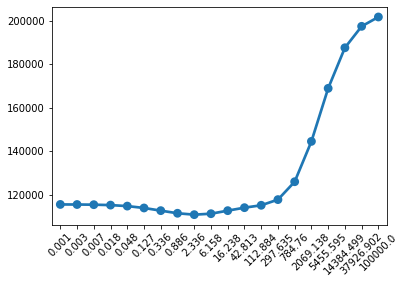

In [68]:
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]

In [69]:
best_model = Ridge(alpha=best, normalize=False).fit(std_X, y)
best_model.coef_

array([-239.45313269,  257.27882445,    7.10862743,   -9.99495044,
          0.31893602,  114.0741681 ,  -48.64787333, -134.01096123,
        125.29187364,   54.41535499,  238.11211279,  126.83291663,
       -161.09598641,   30.65852507,  -61.41713111,   78.21392989,
         42.35482178,  -24.76177155,  -13.85063084])

In [70]:
lambdas = np.logspace(-3, 5, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=10)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(std_X):
        model = Lasso(alpha=l, normalize=False, max_iter=5000).fit(std_X.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(std_X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)

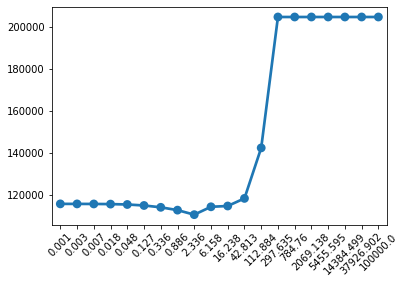

In [71]:
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]

In [73]:
best_model = Lasso(alpha=best, normalize=False).fit(std_X, y)
best_model.coef_

array([-243.57554228,  266.33626856,    0.        ,   -0.        ,
          0.        ,  106.66065606,  -47.66530557,   -0.        ,
          0.        ,   47.06563372,  230.36646236,  122.56821108,
       -150.84129342,   16.39925998,  -59.70133604,   77.08095534,
         27.81502973,  -14.45001133,   -0.        ])

# Lab 3

In [151]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [152]:
X = data.drop(['Salary'], axis=1)
std_X = X / X.std()
y = data.Salary

In [153]:
cv = KFold(n_splits=10, shuffle=True, random_state=13)
res = pd.Series(index=pd.RangeIndex(1, X_reduced.shape[1]), dtype=np.float64)
X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=0.25, random_state=1)
pca_train = PCA()
pca_test = PCA()
X_reduced_train = pca_train.fit_transform(X_train)
X_reduced_test = pca_test.fit_transform(X_test)
for num_components in range(1, X_reduced.shape[1]):
    cv_scores = []
    for train, test in cv.split(X_reduced_train):
        model = LinearRegression().fit(X_reduced_train[train, :num_components], y_train.iloc[train])
        cv_scores.append(mse(y_train.iloc[test], model.predict(X_reduced_train[test, :num_components])))
    res.loc[num_components] = np.mean(cv_scores)

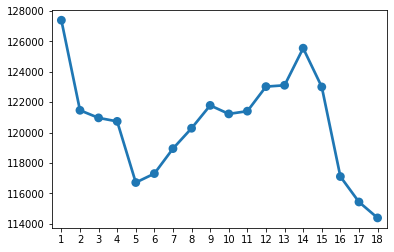

In [154]:
ax = sns.pointplot(res.index, res)
best = res.index[res.argmin()]

In [155]:
from sklearn.cross_decomposition import PLSRegression

In [160]:
cv = KFold(n_splits=10, shuffle=True, random_state=16)
res = pd.Series(index=pd.RangeIndex(1, std_X.shape[1]), dtype=np.float64)
X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=0.25, random_state=12)
for num_components in range(1, std_X.shape[1]):
    cv_scores = []
    for train, test in cv.split(X_train):
        model = PLSRegression(n_components=num_components).fit(X_train.iloc[train], y_train.iloc[train])
        cv_scores.append(mse(y_train.iloc[test], model.predict(X_train.iloc[test])))
    res.loc[num_components] = np.mean(cv_scores)

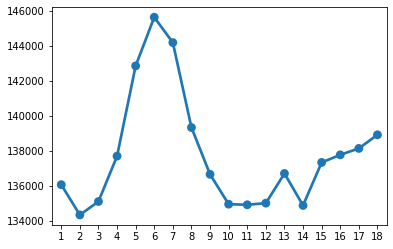

In [161]:
ax = sns.pointplot(res.index, res)
best = res.index[res.argmin()]